# SpamDetector

## Preprocessing

In [384]:
%%python3
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [385]:
%%script bash
python3 FeaturesFromMail.py TR/ TRAIN/ >> /dev/null

In [306]:
# Get labels
import string
import csv
y = list() # y = labels
with open('spam-mail.tr.label','rb') as f :
    labels_reader = csv.reader(f, delimiter=',')
    count_row = 0

    for row in labels_reader:
        if count_row != 0 :
            y.append(row[1])
        count_row = count_row + 1
        
class_names = ['Spam', 'Ham']

In [375]:
def get_features(folder) :
    with open(folder + '/features', 'r') as f :
        features = json.loads(f.read())
        # text = Object + Body + Attachment if .txt + Attachment filenames + X-Mailer
        # nbrHops = # of server where the mail has been received (# of received in mail header)
        # nbrReceivers = total # of receiver in To, Cc and Bcc
        # validityDate = the date mail is valid only if not in the future
        features_name = ['text', 'nbrHops', 'nbrReceivers', 'validityDate']
    return features

In [376]:
features = get_features('TRAIN')
text = features[0]
# Compute TF-IDF features
tfidf = TfidfVectorizer()#stop_words='english', strip_accents='ascii')
tfidf.fit(text) # tfidf remembers the term frequencies and vocabulary that was used to fit it.
X = tfidf.transform(text).todense()

In [363]:
# Divise dataset
def divide_dataset(X, y) :
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = divide_dataset(X, y)

# Classification

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

In [310]:
results = dict()

In [327]:
import time
import datetime
def train(classifier, name, param_grid=None) :
    start_time = time.time()
    if param_grid == None :
        classifier.fit(X_train, y_train)
        results[name] = dict(model=classifier)
    else :
        grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy', n_jobs=2) # Do a 10-fold cross validation
        grid.fit(X, y) # fit the grid with data
        results[name] = dict(grid=grid, model=classifier)
    #total_time = datetime.datetime.fromtimestamp(time.time() - start_time)
    total_time = datetime.timedelta(seconds=time.time() - start_time)
    print("Training time : " + str(total_time))#.strftime('%H:%M:%S'))

## k-NN classifier

In [313]:
name = "k-NN"
classifier = KNeighborsClassifier(weights='uniform')
k_range = list(range(1, 31)) # list of parameter values to test
param_grid = dict(n_neighbors=k_range)
train(classifier, name, param_grid)

Training time : 0:01:29.348193


## Decision tree

In [314]:
name = "Decision tree"
classifier = tree.DecisionTreeClassifier(criterion='entropy')
d_range = list(range(1, 31)) # list of parameter values to test
#s_range = list(range(2, 10))
param_grid = dict(max_depth=d_range)#, min_samples_split=s_range)
train(classifier, name, param_grid)

Training time : 0:01:16.971181


## Naive Bayes

In [358]:
name = "Naive Bayes - Gaussian"
classifier = GaussianNB()
train(classifier, name)

Training time : 0:00:02.102494


In [329]:
name = "Naive Bayes - Multinomial"
classifier = MultinomialNB()
train(classifier, name)

Training time : 0:00:00.277185


In [330]:
name = "Naive Bayes - Bernoulli"
classifier = BernoulliNB()
train(classifier, name)

Training time : 0:00:01.709258


## SVM - Support Vector Machine

In [145]:
name = "SVM - SVC"
classifier = svm.SVC()
C_range = np.logspace(-2, 10, 13)
print C_range
gamma_range = np.logspace(-9, 3, 13)
print gamma_range
param_grid = dict(gamma=gamma_range, C=C_range)
train(classifier, name, param_grid)

In [319]:
name = "SVM - Linear"
classifier = svm.LinearSVC()
C_range = range(170,230,5)
C_range = range(1,200,10)
param_grid = dict(C=C_range)
train(classifier, name, param_grid)

Training time : 0:01:12.919035


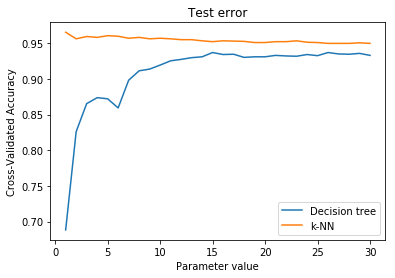

In [334]:
for clf_name, result in results.iteritems() :
    #plt.clf()
    #plt.figure()
    if 'grid' in result and (clf_name == 'k-NN' or clf_name == 'Decision tree'):
        grid = result['grid']
        grid_mean_scores = grid.cv_results_['mean_test_score']
        plt.plot(k_range, grid_mean_scores, label=clf_name)
        plt.title("Test error")
        #plt.title(clf_name)
        plt.legend()
        plt.xlabel('Parameter value')
        plt.ylabel('Cross-Validated Accuracy')
        #plt.show()
    else : # Model without param
        pass

In [336]:
from prettytable import PrettyTable
import operator
t = PrettyTable(['Model', 'Best score', 'Best params', 'FP', 'TN'])
for clf_name, result in results.iteritems() :
    model = result['model']
    if 'grid' in result :
        grid = result['grid']
        # Compute false positives and false negatives
        model.__init__(**grid.best_params_)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        fp = cm[1,0]
        tn = cm[0,1]
        
        t.add_row([clf_name, round(grid.best_score_, 4), grid.best_params_, fp, tn])
        #print(result.best_estimator_)
    else : # For non grid_search models
        #training_error = clf.score(X_train, y_train)
        test_error = model.score(X_test, y_test)
        
        # Compute false positives and false negatives
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        fp = cm[1,0]
        tn = cm[0,1]
        t.add_row([clf_name, round(test_error, 4), None, fp, tn])
        
print t.get_string(sort_key=operator.itemgetter(2, 1), sortby="Best score", reversesort=True)

+---------------------------+------------+--------------------+----+-----+
|           Model           | Best score |    Best params     | FP |  TN |
+---------------------------+------------+--------------------+----+-----+
|        SVM - Linear       |   0.9792   |     {'C': 11}      | 5  |  19 |
|            k-NN           |   0.9652   | {'n_neighbors': 1} | 15 |  20 |
|       Decision tree       |   0.9368   | {'max_depth': 15}  | 33 |  43 |
|   Naive Bayes - Gaussian  |   0.9285   |        None        | 24 |  35 |
| Naive Bayes - Multinomial |   0.8739   |        None        | 0  | 104 |
|  Naive Bayes - Bernoulli  |   0.7636   |        None        | 14 | 181 |
+---------------------------+------------+--------------------+----+-----+


# Prediction

In [386]:
%%script bash
python3 FeaturesFromMail.py TT/ TEST/ >> /dev/null

In [381]:
features_kaggle = get_features('TEST')
text_kaggle = features_kaggle[0]

# Compute TF-IDF features
X_kaggle = tfidf.transform(text_kaggle)

In [382]:
# Train again the classifier on the whole datasets (X, y) including testing datasets
# with the best hyper parameters
model = svm.LinearSVC(C=11)
model.fit(X, y)

# Now predict new mails from the TEST dataset (non-labeled)
y_kaggle = model.predict(X_kaggle)

In [383]:
# Store predicted labels
fd = open('spam-mail.tt.label', 'w')
fd.write('Id,Prediction')

for i in range(0, len(y_kaggle)):
    fd.write('\n%d,%s' % (i+1, y_kaggle[i]))

fd.close()

# Unsupervised - k-means

In [337]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

<class 'numpy.matrixlib.defmatrix.matrix'>


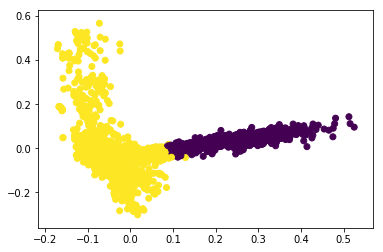

In [356]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=kmeans.labels_)

In [360]:
print kmeans.score(X)

-2393.58620536
